In [3]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [4]:
import numpy as np
import pandas as pd

In [5]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [6]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect
Base = automap_base()

In [7]:
#set up engine
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [8]:
#set up inspector
inspector = inspect(engine)


In [9]:
# reflect an existing database into a new model
Base.prepare(engine, reflect=True)


In [10]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [11]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station


In [12]:
#use inspector to show column names of "Measurement"
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [13]:
#use inspector to show column names of "Station"
columns2 = inspector.get_columns('station')
for column in columns2:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [46]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

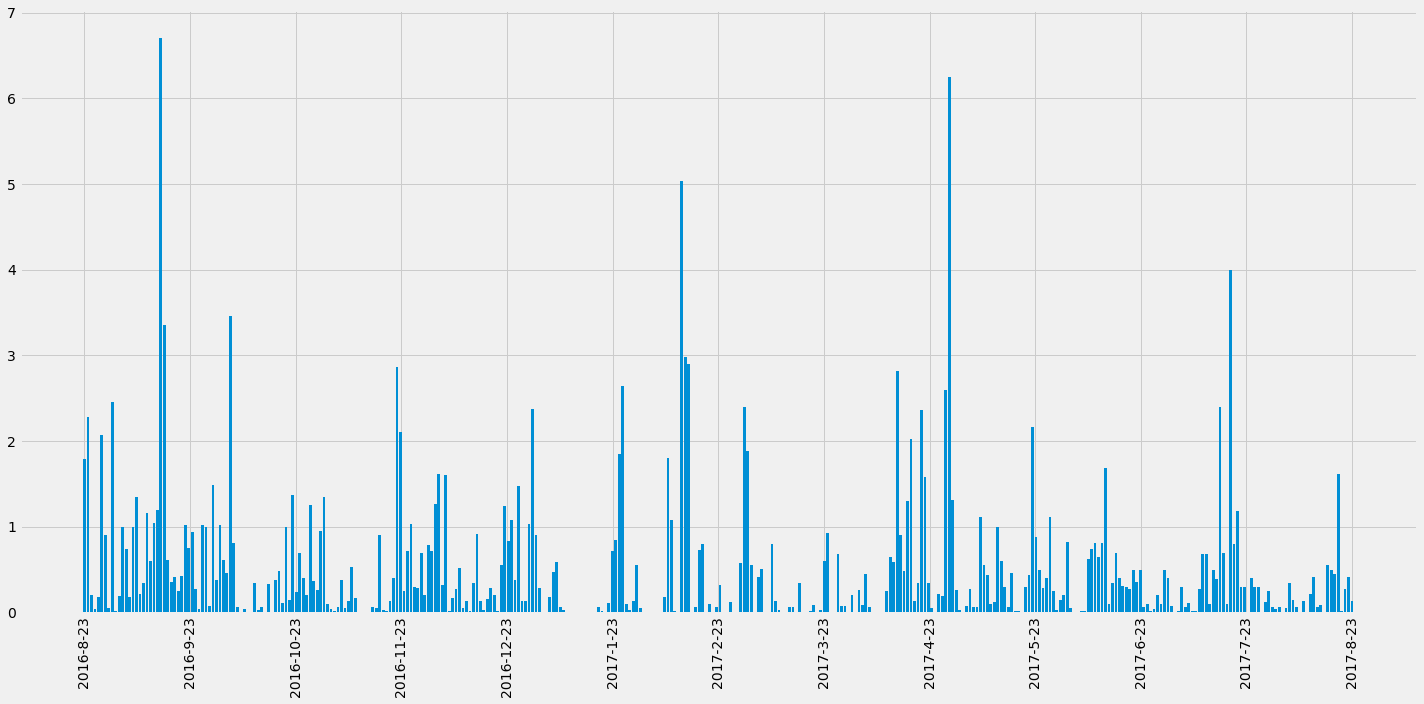

In [15]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results


# Calculate the date 1 year ago from the last data point in the database
query_date = dt.date(2017, 8, 23)-dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores   
precip = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= query_date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(precip, columns=['Date', 'Precipitation'])
precip_df=df['Precipitation']
precip_df.index=df['Date']
precip_df =precip_df.fillna(0)

# Sort the dataframe by date
precip_df.sort_index()

# Use Pandas Plotting with Matplotlib to plot the data

#create a constant to space the x tick labels
width=365/12

#create a bar chart
fig, ax= plt.subplots(figsize=(20, 10))
ax.bar(precip_df.index, precip_df)

#use constant 'width' to space the x ticks
ax.set_xticks([0, width, width*2, width*3, width*4, width*5, width*6, 
               width*7, width*8, width*9, width*10, width*11, width*12])
#name the x ticks
ax.set_xticklabels(['2016-8-23', '2016-9-23', '2016-10-23',
                    '2016-11-23', '2016-12-23', '2017-1-23',
                    '2017-2-23', '2017-3-23', '2017-4-23',
                    '2017-5-23', '2017-6-23', '2017-7-23',
                    '2017-8-23'], rotation=90)
fig.tight_layout()

#save the figure
plt.savefig('C:\\Users\\pmaxl\\OneDrive\\Desktop\\sqlalchemy-challenge\\Images\\precipitation.png')
plt.show()


In [44]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_stats=precip_df.describe()


precip_stats


count    2230.000000
mean        0.160664
std         0.442067
min         0.000000
25%         0.000000
50%         0.010000
75%         0.110000
max         6.700000
Name: Precipitation, dtype: float64

In [17]:
# Design a query to show how many stations are available in this dataset?
no_stations = len(session.query(Station.name).all())
print(f'There are a total of {no_stations} stations.')

There are a total of 9 stations.


In [18]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
  
session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [19]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
temps=session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).filter(Measurement.station == 'USC00519281').all()

#set up loop to print queried stats
for (x, y, z) in temps:
    print("Temperature data for station USC00519281")
    print("========================================")
    print(f'Low:  {x} °F')
    print(f'High:  {y} °F')
    print(f'Avg:  {round(z, 1)} °F')
    

Temperature data for station USC00519281
Low:  54.0 °F
High:  85.0 °F
Avg:  71.7 °F


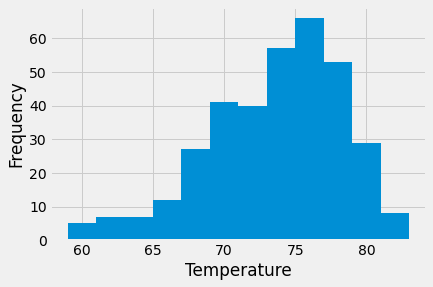

In [29]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

temperatureF = session.query(Measurement.tobs).filter(Measurement.date >= query_date).filter(Measurement.station == 'USC00519281').all()

temp_df = pd.DataFrame(temperatureF, columns=['Temperature'])

#set up histogram with 12 bins
temp_df.Temperature.hist(bins=12)

#set labels
plt.xlabel('Temperature')
plt.ylabel('Frequency')

#save figure
plt.savefig('C:\\Users\\pmaxl\\OneDrive\\Desktop\\sqlalchemy-challenge\\Images\\station-temps.png')
plt.show()

        




## Bonus Challenge Assignment

In [21]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [22]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [23]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [24]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [25]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [26]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [27]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [28]:
# Plot the daily normals as an area plot with `stacked=False`
